## The code

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8251 - loss: 0.4282 - val_accuracy: 0.9350 - val_loss: 0.1787
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9659 - loss: 0.0926 - val_accuracy: 0.9427 - val_loss: 0.1750
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9695 - loss: 0.0770 - val_accuracy: 0.9709 - val_loss: 0.0882
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9739 - loss: 0.0666 - val_accuracy: 0.9660 - val_loss: 0.0934
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9754 - loss: 0.0630 - val_accuracy: 0.9777 - val_loss: 0.0583
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9788 - loss: 0.0501 - val_accuracy: 0.9738 - val_loss: 0.0610
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9892 - loss: 0.0297 - val_accuracy: 0.9777 - val_loss: 0.0652
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9809 - loss: 0.0496 - val_accu

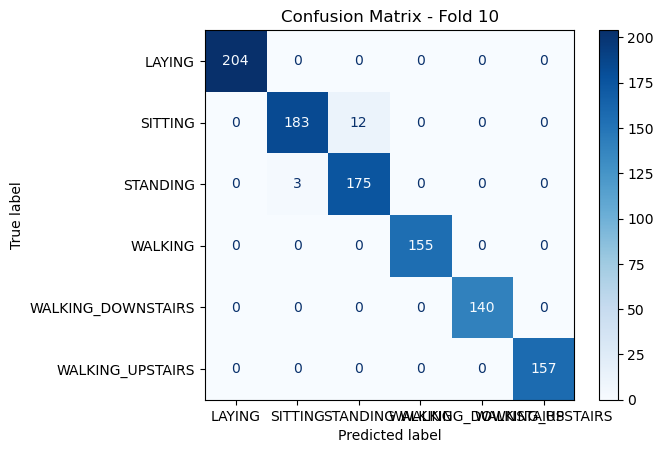

Performance Metrics Per Epoch:
     Fold  Epoch  Accuracy  Val_Accuracy      Loss  Val_Loss
0       1      1  0.908404      0.934951  0.232465  0.178746
1       1      2  0.960406      0.942718  0.103867  0.174968
2       1      3  0.969576      0.970874  0.077602  0.088218
3       1      4  0.976157      0.966019  0.062716  0.093406
4       1      5  0.976589      0.977670  0.063629  0.058250
..    ...    ...       ...           ...       ...       ...
147    10     10  0.991370      0.972789  0.026858  0.065991
148    10     11  0.983495      0.968902  0.046585  0.175671
149    10     12  0.989860      0.984451  0.026399  0.071984
150    10     13  0.991370      0.974733  0.027430  0.089840
151    10     14  0.992125      0.982507  0.022376  0.044203

[152 rows x 6 columns]


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data_path = r'C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Datasets\TimeSeries\Human Activity Recognition with Smartphones (4 classes)\HumanActivity_Data_Preprocessed.csv'
data = pd.read_csv(data_path)

# Drop 'person' column as it's not useful for modeling
data = data.drop('person', axis=1)

# Separate features and labels
X = data.drop(['Activity', 'subject'], axis=1)  # features
y = data['Activity']  # labels

# Encode the 'Activity' labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded)  # One-hot encode the labels

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for Conv1D (3D input: [samples, timesteps, features])
X_scaled = np.expand_dims(X_scaled, axis=1)  # Adding a time dimension (timesteps = 1)

# InceptionTime Model Definition
def inception_module(input_tensor, filters):
    # 1x1 convolution
    conv_1x1 = layers.Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(input_tensor)

    # 3x3 convolution
    conv_3x3 = layers.Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu')(input_tensor)

    # 5x5 convolution
    conv_5x5 = layers.Conv1D(filters=filters, kernel_size=5, padding='same', activation='relu')(input_tensor)

    # MaxPooling followed by 1x1 convolution
    max_pool = layers.MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    max_pool_conv = layers.Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(max_pool)

    # Concatenate all the feature maps
    return layers.concatenate([conv_1x1, conv_3x3, conv_5x5, max_pool_conv], axis=-1)

def build_inception_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Inception modules
    x = inception_module(inputs, filters=32)
    x = inception_module(x, filters=64)
    x = inception_module(x, filters=128)

    # Global Average Pooling and Dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(6, activation='softmax')(x)  # 6 activity classes

    model = models.Model(inputs, outputs)
    return model

# K-Fold Cross-Validation with Early Stopping and Confusion Matrix
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1
results_table = []

for train_idx, test_idx in kfold.split(X_scaled):
    # Split the data for this fold
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_categorical[train_idx], y_categorical[test_idx]
    
    # Build and compile the model
    input_shape = (1, X_train.shape[2])  # Adjust input shape
    model = build_inception_model(input_shape)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping criteria
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, 
                        callbacks=[early_stopping], verbose=1)
    
    # Collect results for each epoch
    for epoch in range(len(history.history['accuracy'])):
        results_table.append({
            'Fold': fold_no,
            'Epoch': epoch + 1,
            'Accuracy': history.history['accuracy'][epoch],
            'Val_Accuracy': history.history['val_accuracy'][epoch],
            'Loss': history.history['loss'][epoch],
            'Val_Loss': history.history['val_loss'][epoch]
        })

    # Evaluate the model on test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Print Confusion Matrix for the last fold
    if fold_no == 10:  # Final fold, display the confusion matrix
        cm = confusion_matrix(y_test_classes, y_pred_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix - Fold {fold_no}')
        plt.show()

    fold_no += 1

# Convert the results table into a DataFrame
results_df = pd.DataFrame(results_table)

# Display the table of results
print("Performance Metrics Per Epoch:")
print(results_df)

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8324 - loss: 0.4168 - val_accuracy: 0.9631 - val_loss: 0.1074
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9616 - loss: 0.0993 - val_accuracy: 0.9699 - val_loss: 0.0914
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9728 - loss: 0.0726 - val_accuracy: 0.9738 - val_loss: 0.0708
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9699 - loss: 0.0805 - val_accuracy: 0.9689 - val_loss: 0.0729
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9805 - loss: 0.0545 - val_accuracy: 0.9689 - val_loss: 0.0875
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9848 - loss: 0.0438 - val_accuracy: 0.9825 - val_loss: 0.0472
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9811 - loss: 0.0477 - val_accuracy: 0.9786 - val_loss: 0.0603
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9835 - loss: 0.0419 - val_acc

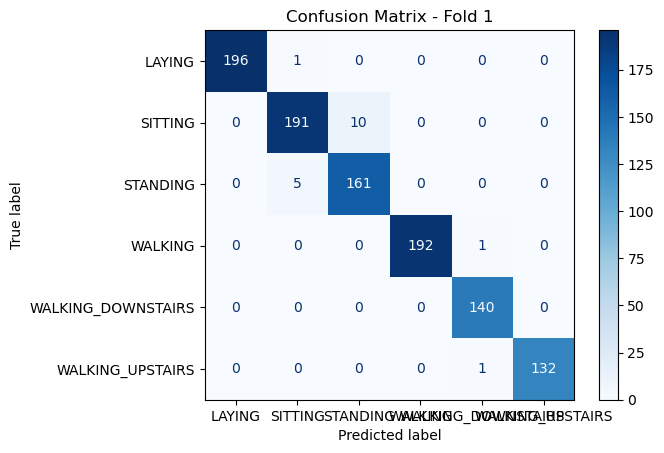

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8218 - loss: 0.4333 - val_accuracy: 0.9417 - val_loss: 0.1590
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9600 - loss: 0.1099 - val_accuracy: 0.9660 - val_loss: 0.0973
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9726 - loss: 0.0735 - val_accuracy: 0.9670 - val_loss: 0.0870
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9761 - loss: 0.0626 - val_accuracy: 0.9573 - val_loss: 0.1158
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9789 - loss: 0.0634 - val_accuracy: 0.9748 - val_loss: 0.0911
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9840 - loss: 0.0468 - val_accuracy: 0.9602 - val_loss: 0.1006
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9881 - loss: 0.0266 - val_accuracy: 0.9680 - val_loss: 0.0784
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9899 - loss: 0.0249 - val_accu

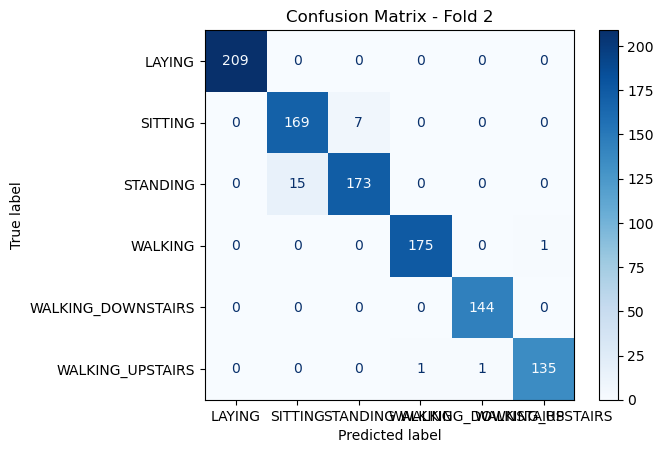

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8192 - loss: 0.4392 - val_accuracy: 0.9524 - val_loss: 0.1168
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9616 - loss: 0.1003 - val_accuracy: 0.9592 - val_loss: 0.1199
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9732 - loss: 0.0724 - val_accuracy: 0.9728 - val_loss: 0.0612
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9776 - loss: 0.0560 - val_accuracy: 0.9748 - val_loss: 0.0617
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9777 - loss: 0.0667 - val_accuracy: 0.9553 - val_loss: 0.1093
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9840 - loss: 0.0408 - val_accuracy: 0.9689 - val_loss: 0.0984
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9796 - loss: 0.0657 - val_accuracy: 0.9864 - val_loss: 0.0473
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9886 - loss: 0.0268 - val_accura

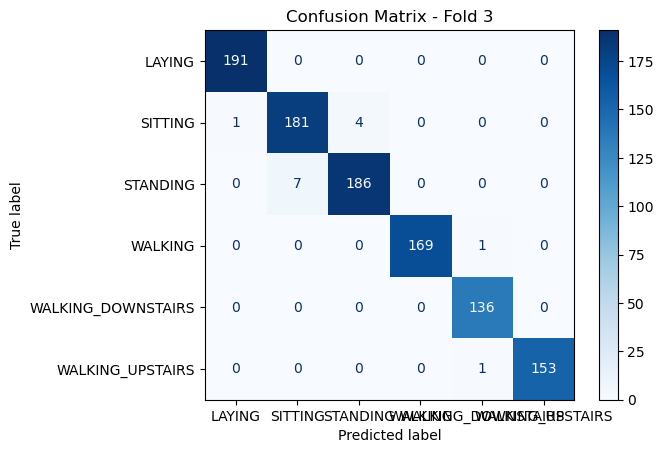

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8306 - loss: 0.4008 - val_accuracy: 0.9534 - val_loss: 0.1056
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9606 - loss: 0.0989 - val_accuracy: 0.9544 - val_loss: 0.1343
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9696 - loss: 0.0820 - val_accuracy: 0.9786 - val_loss: 0.0521
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9758 - loss: 0.0626 - val_accuracy: 0.9806 - val_loss: 0.0508
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9808 - loss: 0.0501 - val_accuracy: 0.9748 - val_loss: 0.0576
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9825 - loss: 0.0426 - val_accuracy: 0.9825 - val_loss: 0.0503
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9824 - loss: 0.0424 - val_accuracy: 0.9874 - val_loss: 0.0386
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9871 - loss: 0.0332 - val_accu

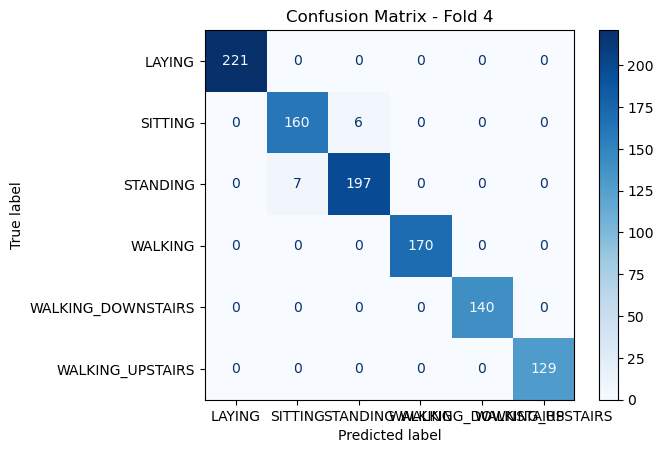

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8165 - loss: 0.4377 - val_accuracy: 0.9563 - val_loss: 0.1183
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9630 - loss: 0.0967 - val_accuracy: 0.9485 - val_loss: 0.1387
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9683 - loss: 0.0799 - val_accuracy: 0.9767 - val_loss: 0.0691
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9744 - loss: 0.0635 - val_accuracy: 0.9777 - val_loss: 0.0758
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9814 - loss: 0.0517 - val_accuracy: 0.9806 - val_loss: 0.0501
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9835 - loss: 0.0390 - val_accuracy: 0.9767 - val_loss: 0.0562
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9857 - loss: 0.0361 - val_accuracy: 0.9495 - val_loss: 0.1556
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9768 - loss: 0.0609 - val_accu

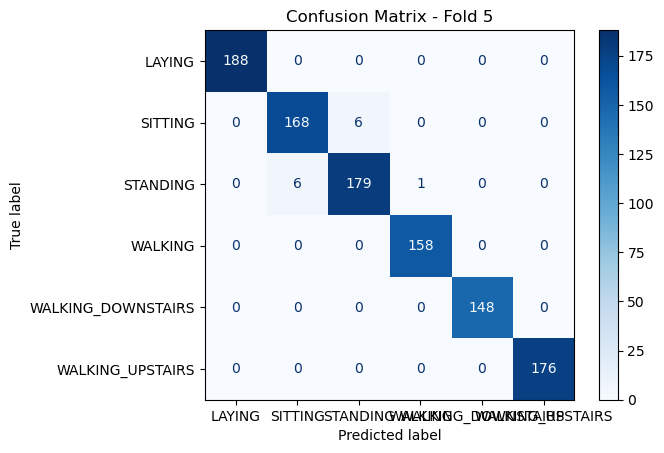

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8330 - loss: 0.4097 - val_accuracy: 0.9136 - val_loss: 0.1995
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9552 - loss: 0.1134 - val_accuracy: 0.9524 - val_loss: 0.1226
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9705 - loss: 0.0807 - val_accuracy: 0.9631 - val_loss: 0.1051
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9816 - loss: 0.0460 - val_accuracy: 0.9660 - val_loss: 0.0883
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9816 - loss: 0.0483 - val_accuracy: 0.9583 - val_loss: 0.1096
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9823 - loss: 0.0438 - val_accuracy: 0.9621 - val_loss: 0.1160
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9845 - loss: 0.0440 - val_accuracy: 0.9563 - val_loss: 0.1299
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9857 - loss: 0.0408 - val_acc

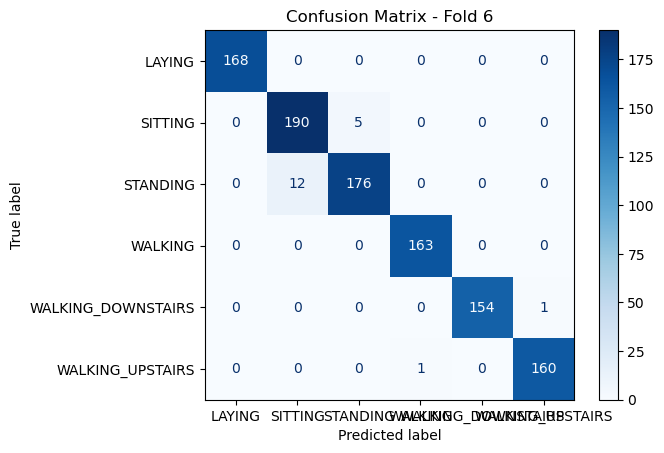

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8326 - loss: 0.4112 - val_accuracy: 0.9650 - val_loss: 0.1043
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9564 - loss: 0.1114 - val_accuracy: 0.9767 - val_loss: 0.0612
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9690 - loss: 0.0789 - val_accuracy: 0.9835 - val_loss: 0.0499
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9809 - loss: 0.0546 - val_accuracy: 0.9816 - val_loss: 0.0640
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9839 - loss: 0.0422 - val_accuracy: 0.9806 - val_loss: 0.0434
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9779 - loss: 0.0710 - val_accuracy: 0.9845 - val_loss: 0.0458
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9824 - loss: 0.0492 - val_accuracy: 0.9835 - val_loss: 0.0617
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9878 - loss: 0.0333 - val_acc

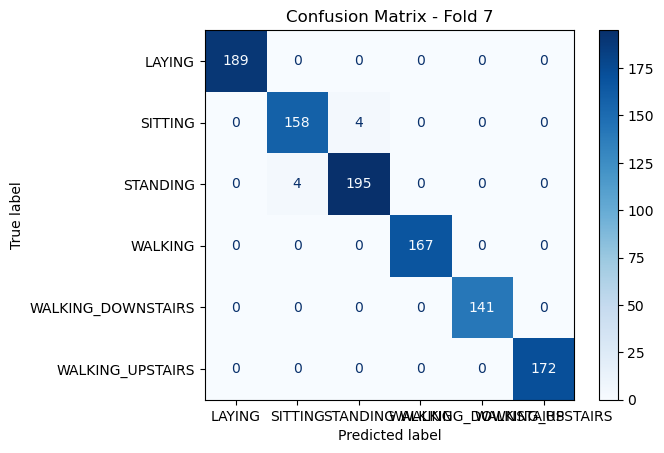

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8220 - loss: 0.4175 - val_accuracy: 0.9583 - val_loss: 0.1117
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9618 - loss: 0.0991 - val_accuracy: 0.9786 - val_loss: 0.0542
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9663 - loss: 0.0792 - val_accuracy: 0.9825 - val_loss: 0.0620
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9762 - loss: 0.0601 - val_accuracy: 0.9825 - val_loss: 0.0530
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9750 - loss: 0.0640 - val_accuracy: 0.9777 - val_loss: 0.0645
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9812 - loss: 0.0518 - val_accuracy: 0.9806 - val_loss: 0.0497
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9784 - loss: 0.0637 - val_accuracy: 0.9728 - val_loss: 0.0790
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9884 - loss: 0.0334 - val_acc

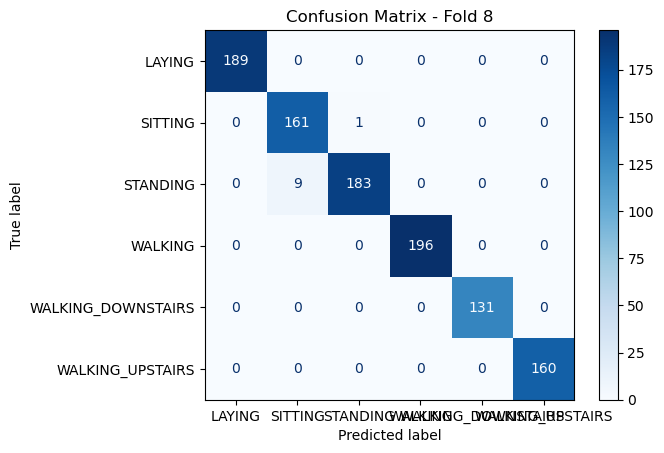

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8280 - loss: 0.4255 - val_accuracy: 0.9534 - val_loss: 0.1305
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9658 - loss: 0.0902 - val_accuracy: 0.9515 - val_loss: 0.1279
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9762 - loss: 0.0666 - val_accuracy: 0.9650 - val_loss: 0.0866
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9757 - loss: 0.0633 - val_accuracy: 0.9583 - val_loss: 0.1056
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9807 - loss: 0.0571 - val_accuracy: 0.9583 - val_loss: 0.1564
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9817 - loss: 0.0513 - val_accuracy: 0.9680 - val_loss: 0.0804
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9889 - loss: 0.0310 - val_accuracy: 0.9515 - val_loss: 0.1512
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9831 - loss: 0.0447 - val_acc

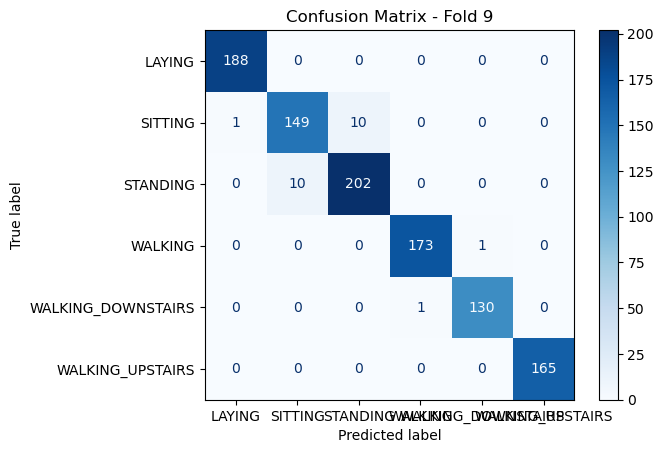

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8206 - loss: 0.4308 - val_accuracy: 0.9543 - val_loss: 0.1220
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9633 - loss: 0.0940 - val_accuracy: 0.9767 - val_loss: 0.0598
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9752 - loss: 0.0689 - val_accuracy: 0.9747 - val_loss: 0.0749
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9783 - loss: 0.0573 - val_accuracy: 0.9718 - val_loss: 0.0940
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9762 - loss: 0.0639 - val_accuracy: 0.9728 - val_loss: 0.0783
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9854 - loss: 0.0410 - val_accuracy: 0.9728 - val_loss: 0.0629
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9832 - loss: 0.0401 - val_accuracy: 0.9806 - val_loss: 0.0391
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9841 - loss: 0.0464 - val_accuracy: 0

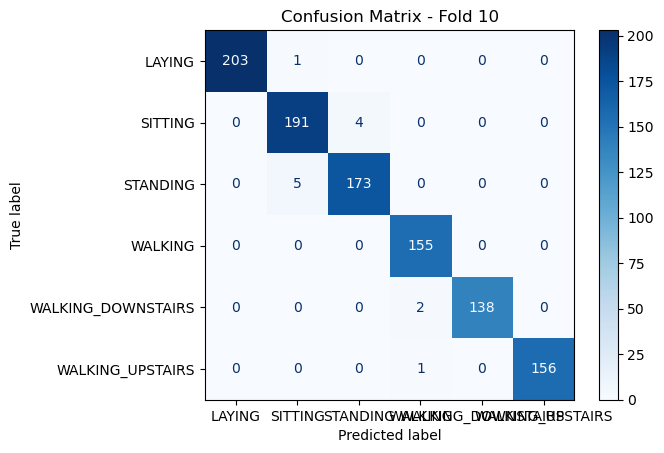

Average Performance Across All Folds:
      Metric  Average Value
0   Accuracy       0.984853
1  Precision       0.984971
2     Recall       0.984853
3   F1-Score       0.984854
Performance Metrics Per Epoch:
     Fold  Epoch  Accuracy  Val_Accuracy      Loss  Val_Loss
0       1      1  0.910131      0.963107  0.231096  0.107392
1       1      2  0.962563      0.969903  0.097515  0.091394
2       1      3  0.969144      0.973786  0.083606  0.070843
3       1      4  0.973784      0.968932  0.067934  0.072909
4       1      5  0.982199      0.968932  0.049632  0.087478
..    ...    ...       ...           ...       ...       ...
165    10     18  0.995469      0.976676  0.017155  0.071392
166    10     19  0.996872      0.990282  0.008898  0.045993
167    10     20  0.994714      0.984451  0.014459  0.065583
168    10     21  0.995146      0.985423  0.014110  0.050802
169    10     22  0.987918      0.984451  0.045453  0.047109

[170 rows x 6 columns]


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load dataset
data_path = r'C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Datasets\TimeSeries\Human Activity Recognition with Smartphones (4 classes)\HumanActivity_Data_Preprocessed.csv'
data = pd.read_csv(data_path)

# Drop 'person' column as it's not useful for modeling
data = data.drop('person', axis=1)

# Separate features and labels
X = data.drop(['Activity', 'subject'], axis=1)  # features
y = data['Activity']  # labels

# Encode the 'Activity' labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded)  # One-hot encode the labels

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for Conv1D (3D input: [samples, timesteps, features])
X_scaled = np.expand_dims(X_scaled, axis=1)  # Adding a time dimension (timesteps = 1)

# InceptionTime Model Definition
def inception_module(input_tensor, filters):
    # 1x1 convolution
    conv_1x1 = layers.Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(input_tensor)

    # 3x3 convolution
    conv_3x3 = layers.Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu')(input_tensor)

    # 5x5 convolution
    conv_5x5 = layers.Conv1D(filters=filters, kernel_size=5, padding='same', activation='relu')(input_tensor)

    # MaxPooling followed by 1x1 convolution
    max_pool = layers.MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    max_pool_conv = layers.Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(max_pool)

    # Concatenate all the feature maps
    return layers.concatenate([conv_1x1, conv_3x3, conv_5x5, max_pool_conv], axis=-1)

def build_inception_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Inception modules
    x = inception_module(inputs, filters=32)
    x = inception_module(x, filters=64)
    x = inception_module(x, filters=128)

    # Global Average Pooling and Dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(6, activation='softmax')(x)  # 6 activity classes

    model = models.Model(inputs, outputs)
    return model

# K-Fold Cross-Validation with Early Stopping and Confusion Matrix
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1
accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_per_fold = []
results_table = []

for train_idx, test_idx in kfold.split(X_scaled):
    # Split the data for this fold
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_categorical[train_idx], y_categorical[test_idx]
    
    # Build and compile the model
    input_shape = (1, X_train.shape[2])  # Adjust input shape
    model = build_inception_model(input_shape)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping criteria
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, 
                        callbacks=[early_stopping], verbose=1)
    
    # Collect results for each epoch
    for epoch in range(len(history.history['accuracy'])):
        results_table.append({
            'Fold': fold_no,
            'Epoch': epoch + 1,
            'Accuracy': history.history['accuracy'][epoch],
            'Val_Accuracy': history.history['val_accuracy'][epoch],
            'Loss': history.history['loss'][epoch],
            'Val_Loss': history.history['val_loss'][epoch]
        })

    # Evaluate the model on test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Calculate performance metrics for this fold
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    
    # Store the metrics for averaging later
    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    # Display Confusion Matrix for each fold
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - Fold {fold_no}')
    plt.show()

    fold_no += 1

# Convert the results table into a DataFrame
results_df = pd.DataFrame(results_table)

# Calculate average performance metrics across all folds
average_accuracy = np.mean(accuracy_per_fold)
average_precision = np.mean(precision_per_fold)
average_recall = np.mean(recall_per_fold)
average_f1 = np.mean(f1_per_fold)

# Create a DataFrame to display the average performance metrics
average_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Average Value': [average_accuracy, average_precision, average_recall, average_f1]
})

# Display the average performance metrics table
print("Average Performance Across All Folds:")
print(average_metrics)

# Display the table of results per epoch
print("Performance Metrics Per Epoch:")
print(results_df)
